## Import

In [1]:
#################################
# # when running google colab # #
#################################
# from google.colab import drive
# drive.mount('/content/gdrive')
# !pip install scikeras --quiet

In [2]:
from IPython.display import clear_output
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from keras.utils.np_utils import to_categorical 
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, \
    BatchNormalization, Flatten, LSTM
# from scikeras.wrappers import KerasClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import roc_curve, auc

from itertools import cycle
from scipy import interp
from scipy.optimize import brentq
from scipy.interpolate import interp1d

N_FEATURES = 31
TIMESTEPS = 1
DATASET_LINK = "dataset/overall.csv"
TEST_DATA_LINK = "dataset/overall_test.csv"

# random seed for reproducibility
SEED = 10

2021-12-03 03:29:58.226817: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-03 03:29:58.226855: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### LOAD DATASET
> * Check for class imbalance

In [3]:
# loading of dataset
df = pd.read_csv(DATASET_LINK)

df.head()

,subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,...,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
0,Andy,1,1,0.142176,0.156880,0.014704,0.127937,0.142299,0.014361,0.155919,...,0.128263,0.085967,-0.042296,0.120442,0.209372,0.088930,0.116911,0.165437,0.048526,0.160258
1,Andy,1,2,0.141793,0.164635,0.022842,0.121625,0.152146,0.030520,0.137039,...,0.144490,0.082397,-0.062093,0.101188,0.126066,0.024878,0.098424,0.130661,0.032238,0.173819
2,Andy,1,3,0.157152,0.147220,-0.009932,0.134796,0.145790,0.010994,0.124892,...,0.135452,0.082423,-0.053029,0.108598,0.155843,0.047244,0.118759,0.146550,0.027791,0.173512
3,Andy,1,4,0.158673,0.142487,-0.016186,0.118908,0.159179,0.040271,0.133175,...,0.114266,0.072556,-0.041711,0.101937,0.145692,0.043755,0.096300,0.122580,0.026280,0.190808
4,Andy,1,5,0.166583,0.157102,-0.009480,0.115094,0.141103,0.026009,0.135121,...,0.125474,0.089247,-0.036227,0.114211,0.149136,0.034925,0.121197,0.230113,0.108917,0.143299


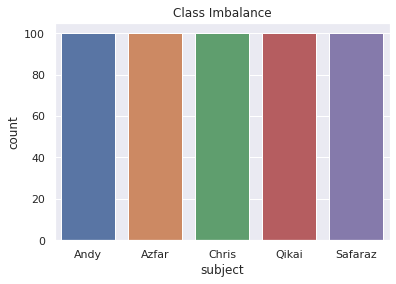

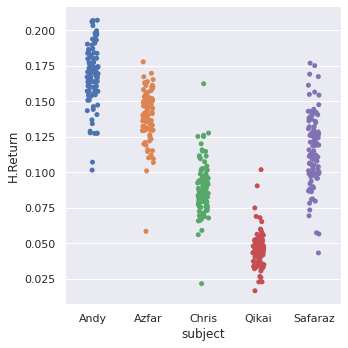

In [4]:
#################################
# # check for class imbalance # #
#################################

sns.set_theme(style="darkgrid")
ax = sns.countplot(x="subject", data=df).set_title("Class Imbalance")

# remove missing values if available
df = df.dropna()

sns.catplot(x="subject", y="H.Return", data=df)

### PREPARING DATASET
> * Split data into X and Y 
> * Convert Y into one-hot-encoding

In [5]:
dataset = df.values

# divide data into features X and target (classes) Y
X = dataset[:,3:].astype(float)
Y = dataset[:,0]

# convert target Y to labelbinarizer Y for model
Y = Y.reshape(-1, 1)
lb = LabelBinarizer().fit(Y)
Y = lb.transform(Y)

#################################
# # get all the encoded class # #
#################################
print("LabelBinarizer is able to decipher: ")
print(lb.classes_)
print("\n")

###########################
# # print X and Y shape # #
###########################
print("X dataset shape: " + str(X.shape))
print("Y dataset shape: " + str(Y.shape))

LabelBinarizer is able to decipher: 
['Andy' 'Azfar' 'Chris' 'Qikai' 'Safaraz']


X dataset shape: (500, 31)
Y dataset shape: (500, 5)


### SPLITTING DATASET
> * Split data into train and test dataset 
> * Reshaping of dataset for LSTM Timesteps

In [6]:
##############################################################
# # split dataset into train and test set of 0.8/0.2 ratio # #
##############################################################
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=SEED)


############################
# # reshaping of dataset # #
############################

# reshaping the dataset to include LSTM Timesteps
X_train = np.asarray(X_train, dtype=np.float32)
X_train = np.reshape(X_train, (X_train.shape[0], TIMESTEPS, X_train.shape[1]))
X_test = np.asarray(X_test, dtype=np.float32)
X_test = np.reshape(X_test, (X_test.shape[0], TIMESTEPS, X_test.shape[1]))

# retrieve number of classes
n_classes = y_train.shape[1]

print("X train shape: " + str(X_train.shape))
print("Y train shape: " + str(y_train.shape))
print("X test shape: " + str(X_test.shape))
print("Y test shape: " + str(y_test.shape))

X train shape: (400, 1, 31)
Y train shape: (400, 5)
X test shape: (100, 1, 31)
Y test shape: (100, 5)


### CREATE MODEL
> * Create base model
> * Wrap it with KerasClassifier

In [7]:
# create base model
def create_base_model():
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, 
                 input_shape=(TIMESTEPS,N_FEATURES)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    # softmax for multi-class classification
    model.add(Flatten())
    model.add(Dense(n_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics=['accuracy'])
    return model

# wrap model in KerasClassifier
def create_model():
    model = KerasClassifier(build_fn=create_base_model, epochs=100, 
                            batch_size=50)
    return model

### INITIATE KFOLD VALIDATION
> * evaluate best kfold validation
> * generate loss and accuracy graph
> * perform actual kfold validation

##### evaluate suitable folds for kfold validation

> folds=2, accuracy=94.250% (min=92.500%, max=96.000%)
> folds=3, accuracy=95.997% (min=94.737%, max=97.015%)
> folds=4, accuracy=95.750% (min=94.000%, max=97.000%)
> folds=5, accuracy=96.500% (min=95.000%, max=97.500%)
> folds=6, accuracy=94.750% (min=92.424%, max=97.015%)
> folds=7, accuracy=95.506% (min=92.982%, max=100.000%)
> folds=8, accuracy=96.250% (min=94.000%, max=98.000%)
> folds=9, accuracy=96.515% (min=93.333%, max=100.000%)
> folds=10, accuracy=96.500% (min=92.500%, max=100.000%)


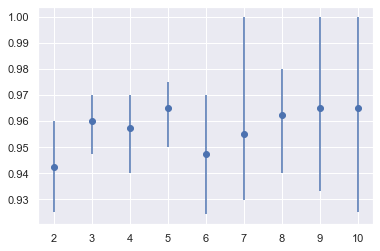

In [8]:
# from sklearn.model_selection import LeaveOneOut
def evaluate_kfold(X_train, y_train, SEED):
    
    # evaluate the model    
    folds = range(2,11)
    means, mins, maxs = list(), list(), list()
    
    # evaluate each k value
    for k in folds:
        # define the test condition
        kfold = KFold(n_splits=k, shuffle=True, random_state=SEED)
        # evaluate k value
        model = create_model()
        scores = cross_val_score(model, X_train, y_train, cv=kfold, n_jobs=-1)
        
        k_mean = np.mean(scores)
        k_min = scores.min()
        k_max = scores.max()
        
        # report performance
        print('> folds=%d, accuracy=%.3f%% (min=%.3f%%, max=%.3f%%)' %
              (k, k_mean*100, k_min*100, k_max*100))
        
        # store mean accuracy
        means.append(k_mean)
        
        # store min and max relative to the mean
        mins.append(k_mean - k_min)
        maxs.append(k_max - k_mean)
        
    # line plot of k mean values with min/max error bars
    clear_output(wait=True)
    pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
    
    # show the plot
    pyplot.show()
    
evaluate_kfold(X_train, y_train, SEED)

##### generate kfold validation accuracy and loss

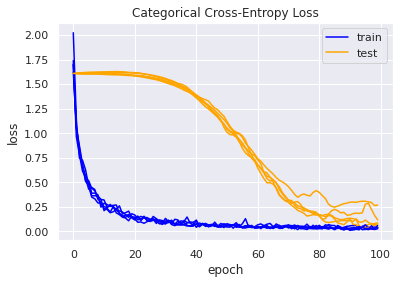

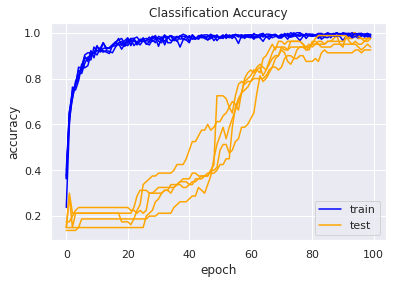

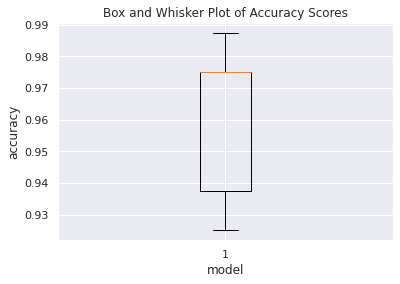

In [9]:
##################################################
# # evaluate kfold model for accuracy and loss # #
##################################################
def evaluate_kfold_model(X_train, y_train, SEED):
    scores, histories = list(), list()
    # create model
    model = create_model()
    # prepare cross validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
    # enumerate splits
    for train_ix, test_ix in kfold.split(X_train):
        # select rows for train and test
        trainX, trainY, testX, testY = X_train[train_ix], y_train[train_ix], X_train[test_ix], y_train[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=100, batch_size=50, validation_data=(testX, testY), verbose=0)
        
        # evaluate model
        y_pred = model.predict(testX)
        y_pred = to_categorical(y_pred)

        # evaluate predictions
        acc = accuracy_score(testY, y_pred)
        print("Testing accuracy: %.3f%%" % (acc*100))

        # stores scores and histories
        scores.append(acc)
        histories.append(history)

    for i in range(len(histories)):
        # plot loss
        f1 = plt.figure(1)
        plt.title('Categorical Cross-Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue')
        plt.plot(histories[i].history['val_loss'], color='orange')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')

        # plot accuracy
        f2 = plt.figure(2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue')
        plt.plot(histories[i].history['val_accuracy'], color='orange')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='lower right')

    # print summary
    print('Accuracy: Mean=%.3f Std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
    # box and whisker plots of results
    f3 = plt.figure(3)
    plt.title('Box and Whisker Plot of Accuracy Scores')
    plt.ylabel('accuracy')
    plt.xlabel('model')
    plt.boxplot(scores)
    clear_output(wait=True)
    plt.show()
    
evaluate_kfold_model(X_train, y_train, SEED)

##### perform actual KFold Validation

In [10]:
# create model
model = create_model()

n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True,
              random_state=SEED)

valid_score = cross_val_score(model, X_train, y_train, 
                          cv=kfold, error_score="raise", verbose=0)

Epoch 1/100
7/7 [==============================] - 4s 8ms/step - loss: 1.8337 - accuracy: 0.3187
Epoch 2/100
7/7 [==============================] - 0s 8ms/step - loss: 1.0046 - accuracy: 0.6469
Epoch 3/100
7/7 [==============================] - 0s 9ms/step - loss: 0.8296 - accuracy: 0.7188
Epoch 4/100
7/7 [==============================] - 0s 9ms/step - loss: 0.6778 - accuracy: 0.7531
Epoch 5/100
7/7 [==============================] - 0s 8ms/step - loss: 0.5077 - accuracy: 0.8156
Epoch 6/100
7/7 [==============================] - 0s 8ms/step - loss: 0.4363 - accuracy: 0.8469
Epoch 7/100
7/7 [==============================] - 0s 9ms/step - loss: 0.4165 - accuracy: 0.8594
Epoch 8/100
7/7 [==============================] - 0s 8ms/step - loss: 0.3260 - accuracy: 0.8938
Epoch 9/100
7/7 [==============================] - 0s 9ms/step - loss: 0.3499 - accuracy: 0.8906
Epoch 10/100
7/7 [==============================] - 0s 12ms/step - loss: 0.2919 - accuracy: 0.9219
Epoch 11/100
7/7 [==========

7/7 [==============================] - 0s 8ms/step - loss: 0.0279 - accuracy: 0.9937
Epoch 85/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0278 - accuracy: 0.9906
Epoch 86/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0322 - accuracy: 0.9875
Epoch 87/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0159 - accuracy: 0.9969
Epoch 88/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0410 - accuracy: 0.9844
Epoch 89/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0625 - accuracy: 0.9781
Epoch 90/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0290 - accuracy: 0.9906
Epoch 91/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0433 - accuracy: 0.9781
Epoch 92/100
7/7 [==============================] - 0s 9ms/step - loss: 0.0131 - accuracy: 0.9937
Epoch 93/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0419 - accuracy: 0.9844
Epoch 94/100
7/7 [===============

7/7 [==============================] - 0s 8ms/step - loss: 0.0189 - accuracy: 0.9969
Epoch 67/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0312 - accuracy: 0.9937
Epoch 68/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0307 - accuracy: 0.9937
Epoch 69/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0265 - accuracy: 0.9969
Epoch 70/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0404 - accuracy: 0.9937
Epoch 71/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0286 - accuracy: 0.9906
Epoch 72/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0304 - accuracy: 0.9906
Epoch 73/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0393 - accuracy: 0.9875
Epoch 74/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0327 - accuracy: 0.9937
Epoch 75/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0229 - accuracy: 0.9937
Epoch 76/100
7/7 [===============

7/7 [==============================] - 0s 10ms/step - loss: 0.0446 - accuracy: 0.9906
Epoch 49/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0779 - accuracy: 0.9812
Epoch 50/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0630 - accuracy: 0.9750
Epoch 51/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0410 - accuracy: 0.9875
Epoch 52/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0464 - accuracy: 0.9812
Epoch 53/100
7/7 [==============================] - 0s 10ms/step - loss: 0.0597 - accuracy: 0.9875
Epoch 54/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0362 - accuracy: 0.9937
Epoch 55/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0627 - accuracy: 0.9750
Epoch 56/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0392 - accuracy: 0.9875
Epoch 57/100
7/7 [==============================] - 0s 9ms/step - loss: 0.0574 - accuracy: 0.9844
Epoch 58/100
7/7 [=============

7/7 [==============================] - 0s 8ms/step - loss: 0.0745 - accuracy: 0.9844
Epoch 31/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0625 - accuracy: 0.9781
Epoch 32/100
7/7 [==============================] - 0s 9ms/step - loss: 0.0701 - accuracy: 0.9781
Epoch 33/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0762 - accuracy: 0.9844
Epoch 34/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0852 - accuracy: 0.9719
Epoch 35/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0965 - accuracy: 0.9688
Epoch 36/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0751 - accuracy: 0.9844
Epoch 37/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0889 - accuracy: 0.9719
Epoch 38/100
7/7 [==============================] - 0s 9ms/step - loss: 0.0791 - accuracy: 0.9812
Epoch 39/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0677 - accuracy: 0.9812
Epoch 40/100
7/7 [===============

7/7 [==============================] - 0s 9ms/step - loss: 0.5765 - accuracy: 0.7937
Epoch 6/100
7/7 [==============================] - 0s 8ms/step - loss: 0.5307 - accuracy: 0.8188
Epoch 7/100
7/7 [==============================] - 0s 8ms/step - loss: 0.4523 - accuracy: 0.8500
Epoch 8/100
7/7 [==============================] - 0s 11ms/step - loss: 0.4260 - accuracy: 0.8594
Epoch 9/100
7/7 [==============================] - 0s 9ms/step - loss: 0.3775 - accuracy: 0.8719
Epoch 10/100
7/7 [==============================] - 0s 9ms/step - loss: 0.2963 - accuracy: 0.9094
Epoch 11/100
7/7 [==============================] - 0s 9ms/step - loss: 0.2833 - accuracy: 0.9094
Epoch 12/100
7/7 [==============================] - 0s 10ms/step - loss: 0.2461 - accuracy: 0.9156
Epoch 13/100
7/7 [==============================] - 0s 8ms/step - loss: 0.2384 - accuracy: 0.9344
Epoch 14/100
7/7 [==============================] - 0s 9ms/step - loss: 0.2271 - accuracy: 0.9375
Epoch 15/100
7/7 [=================

7/7 [==============================] - 0s 8ms/step - loss: 0.0211 - accuracy: 0.9937
Epoch 89/100
7/7 [==============================] - 0s 12ms/step - loss: 0.0210 - accuracy: 0.9937
Epoch 90/100
7/7 [==============================] - 0s 14ms/step - loss: 0.0277 - accuracy: 0.9969
Epoch 91/100
7/7 [==============================] - 0s 12ms/step - loss: 0.0197 - accuracy: 0.9937
Epoch 92/100
7/7 [==============================] - 0s 9ms/step - loss: 0.0206 - accuracy: 0.9969
Epoch 93/100
7/7 [==============================] - 0s 12ms/step - loss: 0.0296 - accuracy: 0.9875
Epoch 94/100
7/7 [==============================] - 0s 9ms/step - loss: 0.0331 - accuracy: 0.9906
Epoch 95/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0624 - accuracy: 0.9844
Epoch 96/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0478 - accuracy: 0.9812
Epoch 97/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0337 - accuracy: 0.9875
Epoch 98/100
7/7 [===========

##### get validation accuracy

In [11]:
print("Validation Accuracy of %.2f%% (with standard deviation of %.2f%%)" % 
      (valid_score.mean()*100, valid_score.std()*100))

Validation Accuracy of 94.75% (with standard deviation of 1.22%)


### FIT MODEL FOR TESTING 
> * fit the model
> * view the accuracy and loss graph
> * view model summary

In [12]:
#####################
# # fit the model # #
#####################
es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                   verbose=1)
history = model.fit(X_train, y_train, callbacks=es, verbose=1)

Epoch 1/100
8/8 [==============================] - 3s 6ms/step - loss: 1.9322 - accuracy: 0.2925
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.9627 - accuracy: 0.6850
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 0.7787 - accuracy: 0.7250
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.6292 - accuracy: 0.7825
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.5119 - accuracy: 0.8225
Epoch 6/100
8/8 [==============================] - 0s 10ms/step - loss: 0.4368 - accuracy: 0.8700
Epoch 7/100
8/8 [==============================] - 0s 8ms/step - loss: 0.4284 - accuracy: 0.8500
Epoch 8/100
8/8 [==============================] - 0s 7ms/step - loss: 0.3313 - accuracy: 0.8900
Epoch 9/100
8/8 [==============================] - 0s 7ms/step - loss: 0.2924 - accuracy: 0.8925
Epoch 10/100
8/8 [==============================] - 0s 8ms/step - loss: 0.2742 - accuracy: 0.9225
Epoch 11/100
8/8 [=======

8/8 [==============================] - 0s 9ms/step - loss: 0.0316 - accuracy: 0.9850
Epoch 85/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0217 - accuracy: 0.9925
Epoch 86/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0375 - accuracy: 0.9875
Epoch 87/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0210 - accuracy: 0.9975
Epoch 88/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0251 - accuracy: 0.9950
Epoch 89/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0216 - accuracy: 0.9900
Epoch 90/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0478 - accuracy: 0.9850
Epoch 91/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0300 - accuracy: 0.9925
Epoch 92/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0277 - accuracy: 0.9875
Epoch 93/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0284 - accuracy: 0.9950
Epoch 94/100
8/8 [============

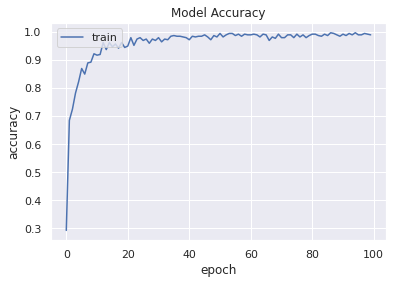

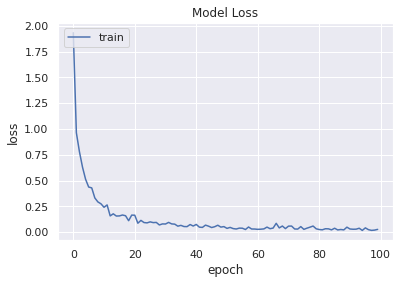

In [13]:
##########################
# # get model accuracy # #
##########################
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

######################
# # get model loss # #
######################
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [14]:
##########################
# # view model summary # #
##########################
model.model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 1, 128)            81920     
                                                                 
 dropout_30 (Dropout)        (None, 1, 128)            0         
                                                                 
 batch_normalization_30 (Bat  (None, 1, 128)           512       
 chNormalization)                                                
                                                                 
 lstm_31 (LSTM)              (None, 1, 128)            131584    
                                                                 
 dropout_31 (Dropout)        (None, 1, 128)            0         
                                                                 
 batch_normalization_31 (Bat  (None, 1, 128)           512       
 chNormalization)                                    

### MODEL TESTING
> * get model accuracy on the test dataset
> * generate confusion matrix
> * generate ROC curves
> * save the model if appropriate

In [15]:
y_pred = model.predict_proba(X_test)

# evaluate predictions
acc = accuracy_score(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
print("Testing accuracy: %.3f%%" % (acc*100))

Testing accuracy: 94.000%


##### Confusion Matrix

<AxesSubplot:>

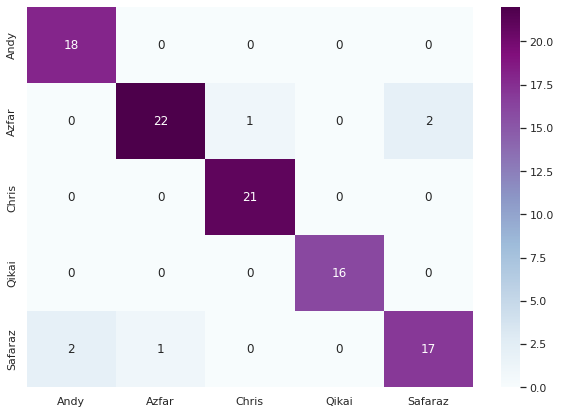

In [16]:
# confusion matrix
cm = confusion_matrix(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
df_cm = pd.DataFrame(cm, index = [i for i in np.unique(lb.inverse_transform(y_test))],
                     columns = [i for i in np.unique(lb.inverse_transform(y_test))])

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap="BuPu")

##### ROC Curve (Individual)

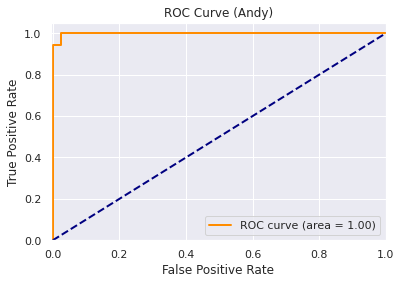

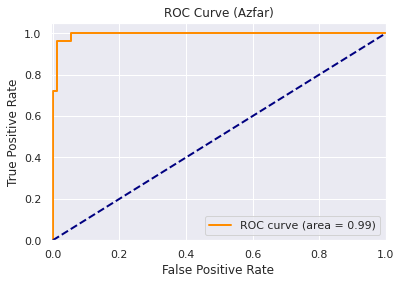

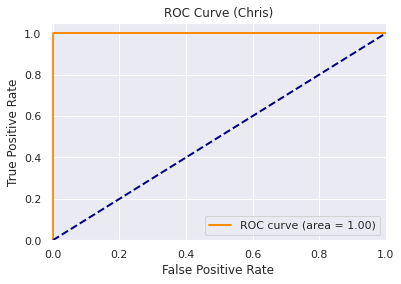

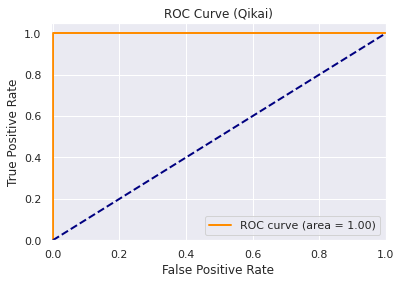

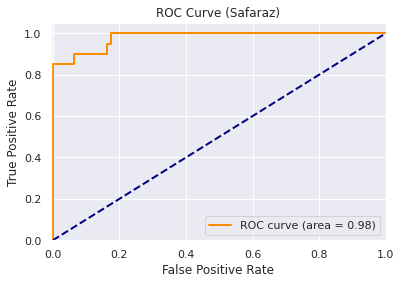

In [17]:
# compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.figure()
    lw = 2
    plt.plot(
        fpr[i],
        tpr[i],
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc[i],
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([-0.005, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (" + str(lb.classes_[i]) + ")")
    plt.legend(loc="lower right")
    plt.show()

##### ROC Curve (Combined Plot)

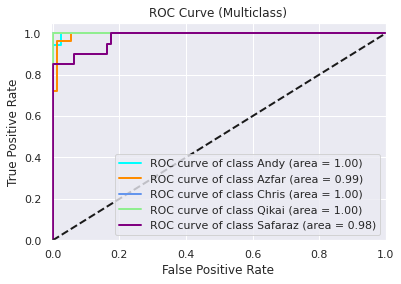

In [18]:
# compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], thresholds = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# first aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
# plt.figure()
# plt.plot(
#     fpr["micro"],
#     tpr["micro"],
#     label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
#     color="deeppink",
#     linestyle=":",
#     linewidth=4,
# )

# plt.plot(
#     fpr["macro"],
#     tpr["macro"],
#     label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
#     color="navy",
#     linestyle=":",
#     linewidth=4,
# )

colors = cycle(["aqua", "darkorange", "cornflowerblue", "lightgreen", "purple"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(lb.classes_[i], roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([-0.005, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Multiclass)")
plt.legend(loc="lower right")
plt.show()

##### ROC Curve (Average out)

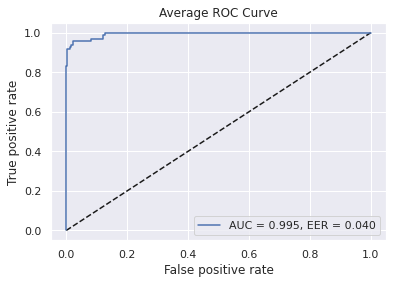

In [19]:
fpr, tpr, threshold = roc_curve(y_test.ravel(), y_pred.ravel())

# calculate equal-error-rate
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}, EER = {:.3f}'.format(auc(fpr, tpr), eer))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Average ROC Curve')
plt.legend(loc='best')
plt.show()

### FIT AND SAVE MODEL
> * fitting of model
> * get accuracy and loss of model
> * saving model

In [20]:
############################
# # reshaping of dataset # #
############################
# loading of dataset
df = pd.read_csv(DATASET_LINK)

df.head()
dataset = df.values

# divide data into features X and target (classes) Y
X = dataset[:,3:].astype(float)
Y = dataset[:,0]

# convert target Y to labelbinarizer Y for model
Y = Y.reshape(-1, 1)
lb = LabelBinarizer().fit(Y)
Y = lb.transform(Y)

# reshaping the dataset to include LSTM Timesteps
X = np.asarray(X, dtype=np.float32)
X = np.reshape(X, (X.shape[0], TIMESTEPS, X.shape[1]))

#####################
# # fit the model # #
#####################

model = create_model()
es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                   verbose=0)
history = model.fit(X, Y, callbacks=es)

Epoch 1/100
10/10 [==============================] - 4s 10ms/step - loss: 1.4902 - accuracy: 0.4680
Epoch 2/100
10/10 [==============================] - 0s 10ms/step - loss: 0.8745 - accuracy: 0.6920
Epoch 3/100
10/10 [==============================] - 0s 11ms/step - loss: 0.6417 - accuracy: 0.7880
Epoch 4/100
10/10 [==============================] - 0s 9ms/step - loss: 0.5783 - accuracy: 0.8000
Epoch 5/100
10/10 [==============================] - 0s 10ms/step - loss: 0.4214 - accuracy: 0.8620
Epoch 6/100
10/10 [==============================] - 0s 10ms/step - loss: 0.3550 - accuracy: 0.8880
Epoch 7/100
10/10 [==============================] - 0s 12ms/step - loss: 0.3113 - accuracy: 0.8940
Epoch 8/100
10/10 [==============================] - 0s 10ms/step - loss: 0.2777 - accuracy: 0.9220
Epoch 9/100
10/10 [==============================] - 0s 9ms/step - loss: 0.2349 - accuracy: 0.9120
Epoch 10/100
10/10 [==============================] - 0s 10ms/step - loss: 0.2524 - accuracy: 0.9300
E

10/10 [==============================] - 0s 7ms/step - loss: 0.0288 - accuracy: 0.9900
Epoch 83/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0278 - accuracy: 0.9880
Epoch 84/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0161 - accuracy: 0.9980
Epoch 85/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0288 - accuracy: 0.9900
Epoch 86/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0349 - accuracy: 0.9880
Epoch 87/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0229 - accuracy: 0.9920
Epoch 88/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0172 - accuracy: 0.9960
Epoch 89/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0214 - accuracy: 0.9940
Epoch 90/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0220 - accuracy: 0.9920
Epoch 91/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0279 - accuracy: 0.9900
Epoch 92/100


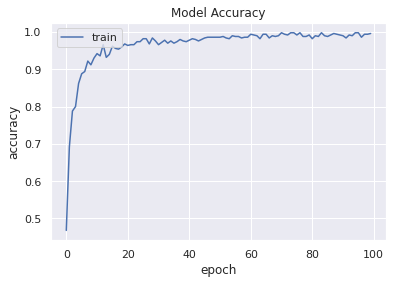

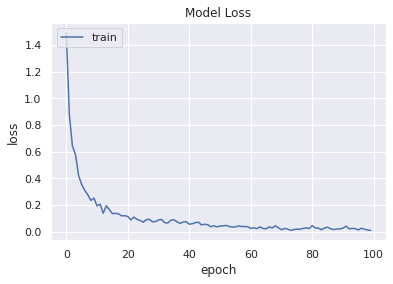

In [21]:
##########################
# # get model accuracy # #
##########################
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

######################
# # get model loss # #
######################
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

### SAVE MODEL

In [22]:
##################
# # save model # #
##################

model.model.save("model/key_classifier.h5")

###########################
# # save model in colab # #
###########################

# model.model.save(F"/content/gdrive/My Drive/Colab Notebooks/overall_key_classifier.h5")

### LOAD MODEL

In [23]:
# ##################
# # # load model # #
# ##################

# model = create_model()
model = load_model("model/key_classifier.h5")

# ###########################
# # # load model in colab # #
# ###########################

# # model.model = load_model("/content/gdrive/My Drive/Colab Notebooks/overall_key_classifier.h5")

### LIVE TESTING
> * import any new data to perform testing and prediction

In [24]:
# import unseen data
pred_df = pd.read_csv(TEST_DATA_LINK)
pred_df.head()

,subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,...,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
0,Andy,1,1,0.174239,0.409866,0.235627,0.133840,0.171659,0.037820,0.156984,...,0.137544,0.091721,-0.045824,0.099726,0.099142,-0.000585,0.120912,0.135934,0.015022,0.163508
1,Andy,1,2,0.145289,0.154851,0.009562,0.131217,0.129134,-0.002083,0.130980,...,0.164865,0.111584,-0.053281,0.101935,0.023678,-0.078258,0.140863,0.192325,0.051462,0.156958
2,Andy,1,3,0.122266,0.136321,0.014055,0.114905,0.125308,0.010402,0.144332,...,0.145501,0.095982,-0.049520,0.121049,0.091486,-0.029563,0.111422,0.145751,0.034329,0.169304
3,Andy,1,4,0.121075,0.132562,0.011487,0.134813,0.132049,-0.002763,0.135681,...,0.135072,0.089715,-0.045356,0.117885,0.089209,-0.028676,0.098095,0.139069,0.040974,0.168298
4,Andy,1,5,0.141361,0.124721,-0.016640,0.098268,0.149003,0.050735,0.128713,...,0.121480,0.078897,-0.042583,0.108607,0.049435,-0.059172,0.131348,0.156398,0.025050,0.170112


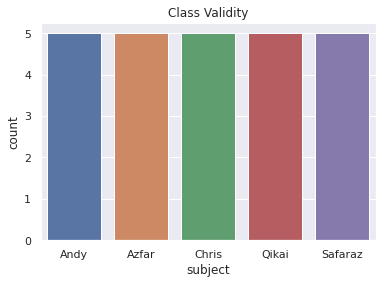

In [25]:
################################
# # check for class validity # #
################################
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="subject", data=pred_df).set_title("Class Validity")

# remove missing values if available
pred_df = pred_df.dropna()

In [28]:
pred_dataset = pred_df.values

# # divide data into features X
# pred_row = pred_dataset[:,3:].astype(float)

#################################
# # predict more than one row # #
#################################

pred_row=pred_df.iloc[:,3:]

############################
# # predict a single row # #
############################

# pred_row=pred_df.iloc[11:12,3:]

##################
# # shape data # #
##################
pred_row = pred_row.values.tolist()
pred_arr = np.asarray(pred_row, dtype=np.float32)
pred_arr = np.reshape(pred_arr, (pred_arr.shape[0], TIMESTEPS, pred_arr.shape[1]))

Y = ['Andy', 'Azfar', 'Chris', 'Qikai', 'Safaraz']
Y = np.asarray(Y)
Y = Y.reshape(-1, 1)
lb = LabelBinarizer().fit(Y)
Y = lb.transform(Y)

In [29]:
####################################
# # get prediction and its label # #
####################################

pred_proba = model.predict(pred_arr)
pred = lb.inverse_transform(pred_proba)
acc = np.max(pred_proba, axis=1)

pred_results = np.column_stack((pred, acc))

df = pd.DataFrame(data=pred_results, index=None, columns=['Prediction', 'Accuracy'])
print(df)

   Prediction    Accuracy
0        Andy  0.99994445
1        Andy    0.999961
2        Andy   0.9998634
3        Andy  0.99993694
4        Andy   0.9997607
5       Azfar   0.9999558
6       Azfar   0.9998752
7       Azfar  0.99991834
8       Azfar   0.9999522
9       Azfar  0.99998355
10      Chris   0.9982836
11      Chris   0.9996898
12      Chris  0.99995875
13      Chris   0.9999405
14      Chris   0.9996598
15      Qikai   0.9983014
16      Qikai  0.99972814
17      Qikai  0.99951327
18      Qikai   0.9906212
19      Qikai   0.9989359
20    Safaraz   0.9998265
21    Safaraz  0.99889237
22    Safaraz   0.9997981
23    Safaraz   0.9993517
24    Safaraz   0.9990097
